# 0. Import Energy Extraction Switch data from CALS db
## 0.1. Import packages

In [2]:
# importing required modules
import pandas as pd
from lhcsmapi.dbsignal.Signal import Signal
from lhcsmapi.dbsignal.SignalAnalysis import SignalAnalysis
from lhcsmapi.dbsignal.SignalUtilities import SignalUtilities
from lhcsmapi.dbsignal.cals.CalsDbSignal import  CalsDbSignal
import pytimber
import numpy as np
ldb = pytimber.LoggingDB()

# 1. Query I_MEAS from CALS (raw current)

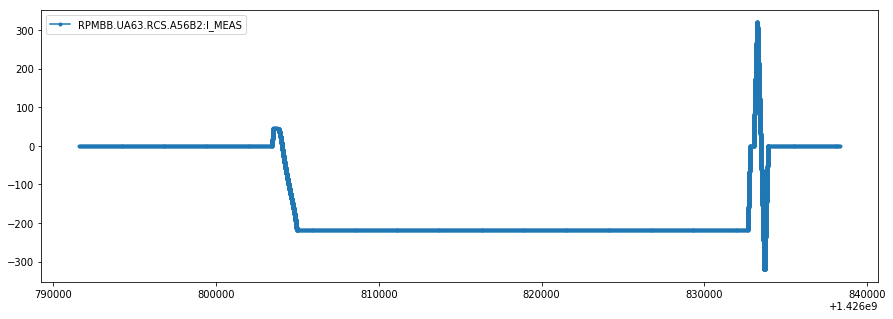

In [3]:
I_MEAS = "RPMBB.UA63.RCS.A56B2:I_MEAS"
t_start='2015-03-19 20:00:00'
t_end = '2015-03-20 09:00:00'
i_meas_df = Signal().read('cals', signal=I_MEAS, t_start=t_start, t_end=t_end, ldb=ldb)
i_meas_df.plot(marker = '.', figsize=(15,5))

## 1.1. I_MEAS summary

In [4]:
i_meas_df.describe()

RPMBB.UA63.RCS.A56B2:I_MEAS
count                  4359.000000
mean                    -61.182131
std                     144.793530
min                    -319.990000
25%                    -182.070000
50%                     -75.810000
75%                      10.315000
max                     319.880000

## 1.2. Query I_MEAS from CALS (raw current)

0.5     2937
60.0     740
1.0      635
1.5       19
2.0        7
Name: time, dtype: int64

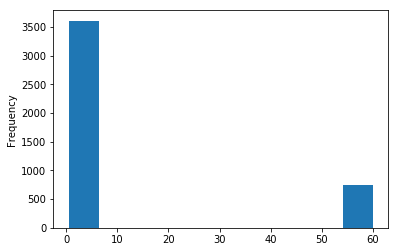

In [5]:
i_meas_df['time'] = i_meas_df.index
i_meas_df['time'].diff().plot.hist(bins = 10)
i_meas_df['time'].diff().dropna().value_counts().head()

## 1.3. Resample time with 1 s sampling period

In [6]:
i_meas_df = SignalAnalysis.resample(i_meas_df, 1) # for plotting
i_meas_df.head()

RPMBB.UA63.RCS.A56B2:I_MEAS          time
1.426792e+09                          0.0  1.426792e+09
1.426792e+09                          0.0  1.426792e+09
1.426792e+09                          0.0  1.426792e+09
1.426792e+09                          0.0  1.426792e+09
1.426792e+09                          0.0  1.426792e+09

## 1.4. I_MEAS_AVG summary

In [7]:
i_meas_df.describe()

RPMBB.UA63.RCS.A56B2:I_MEAS          time
count                 46733.000000  4.673300e+04
mean                   -131.064019  1.426815e+09
std                     109.524632  1.349109e+04
min                    -319.980007  1.426792e+09
25%                    -217.760000  1.426803e+09
50%                    -217.760000  1.426815e+09
75%                       0.000000  1.426827e+09
max                     319.862874  1.426838e+09

## 1.5. I_MEAS_AVG time distribution

RPMBB.UA63.RCS.A56B2:I_MEAS          time
0                          0.0  1.426792e+09
1                          0.0  1.426792e+09
2                          0.0  1.426792e+09
3                          0.0  1.426792e+09
4                          0.0  1.426792e+09

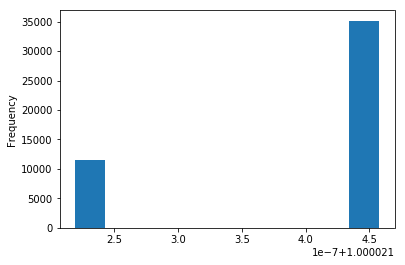

In [8]:
i_meas_df['time'] = i_meas_df.index
i_meas_df['time'].diff().plot.hist(bins = 10)
i_meas_df['time'].diff().dropna().value_counts()
i_meas_df = i_meas_df.reset_index()
i_meas_df = i_meas_df.drop(columns = ["index"])
i_meas_df.head()

## 1.7. Derivative of I_MEAS_AVG

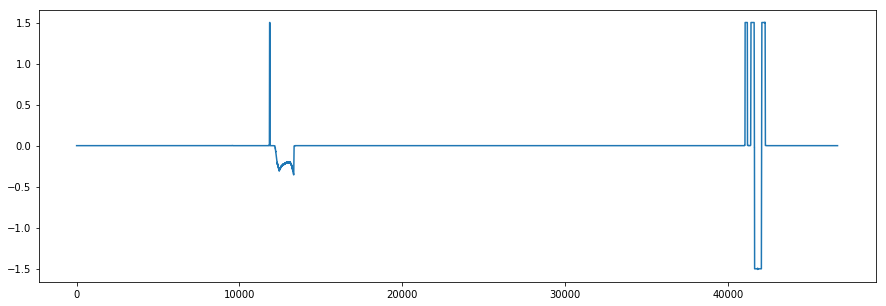

In [10]:
i_meas_df['dI_MEAS'] = i_meas_df[I_MEAS].diff()
i_meas_df['dtime'] = i_meas_df['time'].diff()
i_meas_df = i_meas_df.dropna()
i_meas_df = i_meas_df.assign(dI_MEAS_dt = lambda df: df['dI_MEAS']/df['dtime'])
i_meas_df['dI_MEAS_dt'].plot(figsize=(15,5))

## 1.8. Round to the nearest integer

In [11]:
i_meas_df['round_dI_MEAS_dt'] = i_meas_df.apply(lambda row: np.around(row['dI_MEAS_dt']), axis = 1)

## 1.9. Get sign of the round value

In [12]:
i_meas_df['sign_dI_MEAS_dt'] = i_meas_df.apply(lambda row: np.sign(row['round_dI_MEAS_dt']), axis = 1)

## 1.10. Plot current and sign in one plot

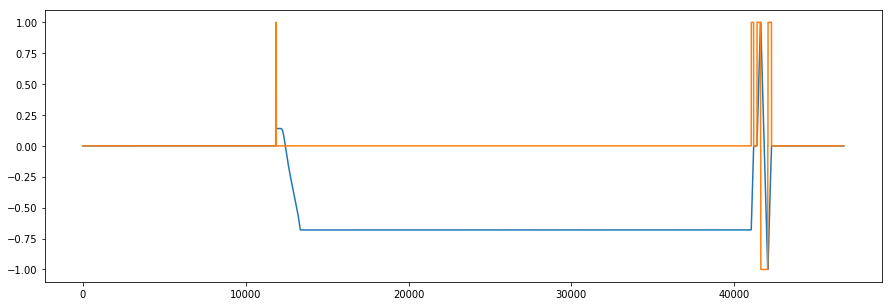

In [14]:
i_meas_df['norm_I_MEAS'] = i_meas_df[I_MEAS]/max(i_meas_df[I_MEAS])
ax = i_meas_df['norm_I_MEAS'].plot(figsize=(15,5))
i_meas_df['sign_dI_MEAS_dt'].plot(ax = ax)

## 1.11. Find value-change rows

In [15]:
i_meas_df['change_sign_dI_MEAS_dt'] = i_meas_df['sign_dI_MEAS_dt'].diff()
DI_MEAS_DT_CHANGE = i_meas_df[i_meas_df['change_sign_dI_MEAS_dt'] != 0]
DI_MEAS_DT_CHANGE = DI_MEAS_DT_CHANGE.dropna()
DI_MEAS_DT_CHANGE

RPMBB.UA63.RCS.A56B2:I_MEAS          time   dI_MEAS     dtime  \
11843                     1.800136  1.426803e+09  1.316869  1.000021   
11873                    45.020000  1.426803e+09  0.187735  1.000021   
41049                  -215.952412  1.426833e+09  1.329757  1.000021   
41194                    -0.187209  1.426833e+09  0.099983  1.000021   
41401                     1.330147  1.426833e+09  0.627196  1.000021   
41617                   319.851542  1.426833e+09  0.334090  1.000021   
41632                   318.540758  1.426833e+09 -0.666002  1.000021   
42061                  -319.790012  1.426834e+09 -0.339999  1.000021   
42076                  -318.659742  1.426834e+09  0.630084  1.000021   
42292                    -0.144703  1.426834e+09  0.330912  1.000021   

       dI_MEAS_dt  round_dI_MEAS_dt  sign_dI_MEAS_dt  norm_I_MEAS  \
11843    1.316841               1.0              1.0     0.005628   
11873    0.187731               0.0              0.0     0.140748   
41049    1.329728               1.0              1.0    -0.675141   
41194    0.099981               0.0              0.0    -0.000585   
41401    0.627182               1.0              1.0     0.004158   
41617    0.334083               0.0              0.0     0.999965   
41632   -0.665988              -1.0             -1.0     0.995867   
42061   -0.339992              -0.0              0.0    -0.999772   
42076    0.630071               1.0              1.0    -0.996239   
42292    0.330905               0.0              0.0    -0.000452   

       change_sign_dI_MEAS_dt  
11843                     1.0  
11873                    -1.0  
41049                     1.0  
41194                    -1.0  
41401                     1.0  
41617                    -1.0  
41632                    -1.0  
42061                     1.0  
42076                     1.0  
42292                    -1.0

## 1.12. Find indices of value-change rows

In [16]:
pattern = [0,1,0,-1,0,1,0]
exactPatternDf, indices = SignalAnalysis.find_rows_with_exact_pattern_in_series(DI_MEAS_DT_CHANGE['sign_dI_MEAS_dt'], pattern)
exactPatternDf

0      1      0     -1      0      1      0
0  41194  41401  41617  41632  42061  42076  42292

## 1.13. Detect Positive Plateau

In [17]:
indexStartPosPlateau = exactPatternDf.iloc[0, 2]
indexEndPosPlateau = exactPatternDf.iloc[0, 3]
timeStartPosPlateau = DI_MEAS_DT_CHANGE[DI_MEAS_DT_CHANGE.index == indexStartPosPlateau]['time'].values[0]
timeEndPosPlateau = DI_MEAS_DT_CHANGE[DI_MEAS_DT_CHANGE.index == indexEndPosPlateau]['time'].values[0]
print('Positive plateau spans idx = [{}, {}]'.format(indexStartPosPlateau, indexEndPosPlateau))
print('Positive plateau spans t = [{}, {}] s'.format(timeStartPosPlateau, timeEndPosPlateau))

Positive plateau spans idx = [41617, 41632]
Positive plateau spans t = [1426833238.390546, 1426833253.390867] s


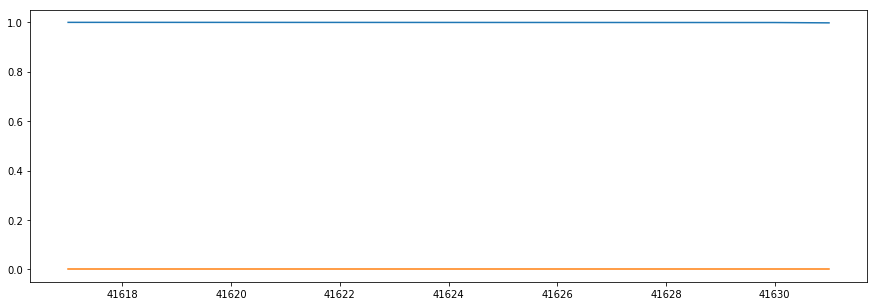

In [21]:
indicesPosPlateau = (i_meas_df.index >= indexStartPosPlateau) & (i_meas_df.index < indexEndPosPlateau)
ax1 = i_meas_df[indicesPosPlateau]['norm_I_MEAS'].plot(figsize=(15,5))
i_meas_df[indicesPosPlateau]['sign_dI_MEAS_dt'].plot(ax = ax1)

## 1.14. Calculate Average Current for Positive Plateau

In [22]:
avgCurrentPosPlateau = np.mean(i_meas_df[indicesPosPlateau][I_MEAS])
avgCurrentPosPlateau

319.71837521352523

## 1.15. Detect Positive Plateau

In [23]:
indexStartNegPlateau = exactPatternDf.iloc[0, 4]
indexEndNegPlateau = exactPatternDf.iloc[0, 5]
timeStartNegPlateau = DI_MEAS_DT_CHANGE[DI_MEAS_DT_CHANGE.index == indexStartNegPlateau]['time'].values[0]
timeEndNegPlateau = DI_MEAS_DT_CHANGE[DI_MEAS_DT_CHANGE.index == indexEndNegPlateau]['time'].values[0]
print('Negative plateau spans idx = [{}, {}]'.format(indexStartNegPlateau, indexEndNegPlateau))
print('Negative plateau spans t = [{}, {}] s'.format(timeStartNegPlateau, timeEndNegPlateau))

Negative plateau spans idx = [42061, 42076]
Negative plateau spans t = [1426833682.400047, 1426833697.400368] s


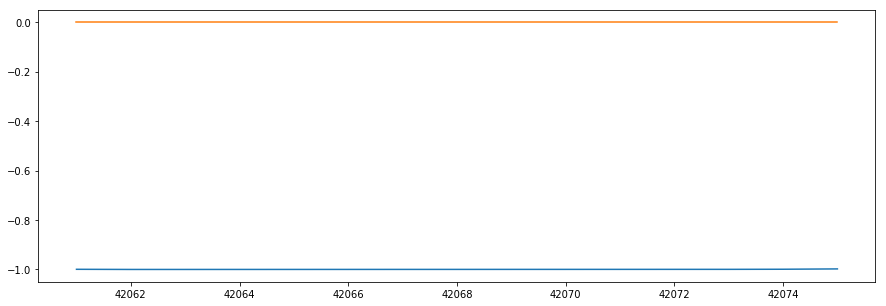

In [24]:
indicesNegPlateau = (i_meas_df.index >= indexStartNegPlateau) & (i_meas_df.index < indexEndNegPlateau)
ax1 = i_meas_df[indicesNegPlateau]['norm_I_MEAS'].plot(figsize=(15,5))
i_meas_df[indicesNegPlateau]['sign_dI_MEAS_dt'].plot(ax = ax1)

## 1.16. Calculate Average Current for Positive Plateau

In [25]:
avgCurrentNegPlateau = np.mean(i_meas_df[indicesNegPlateau][I_MEAS])
avgCurrentNegPlateau

-319.85487984425777

# 2. Query U_DUMP_RES from CALS (raw voltage)

In [28]:
U_DUMP_RES = "DQEMC.UA63.RCS.A56B2:U_DUMP_RES"

## 2.1. Positive plateau

In [31]:
u_dump_res_df = Signal().read('cals', signal=U_DUMP_RES, t_start=t_start, 
                               t_end=t_end, ldb=ldb)
u_dump_res_df.head()

DQEMC.UA63.RCS.A56B2:U_DUMP_RES
1.426792e+09                         5.877609
1.426792e+09                         5.877609
1.426792e+09                         6.171490
1.426792e+09                         6.171490
1.426792e+09                         5.877609

In [32]:
u_dump_res_pos_df = u_dump_res_df[(u_dump_res_df.index >= timeStartPosPlateau) & (u_dump_res_df.index <= timeEndPosPlateau)]
u_dump_res_pos_df.describe()

DQEMC.UA63.RCS.A56B2:U_DUMP_RES
count                        37.000000
mean                          5.837896
std                           0.197896
min                           5.583729
25%                           5.583729
50%                           5.877609
75%                           5.877609
max                           6.171490

## 2.2. Average value

In [33]:
avgVoltagePosPlateau = np.nanmean(u_dump_res_pos_df)
avgVoltagePosPlateau

5.837895676896379

## 2.3. Negative plateau

In [35]:
u_dump_res_neg_df = u_dump_res_df[(u_dump_res_df.index >= timeStartNegPlateau) & (u_dump_res_df.index <= timeEndNegPlateau)]
u_dump_res_neg_df.describe()

DQEMC.UA63.RCS.A56B2:U_DUMP_RES
count                        36.000000
mean                          6.024549
std                           0.164753
min                           5.583729
25%                           5.877609
50%                           6.171490
75%                           6.171490
max                           6.171490

## 2.4. Average value

In [36]:
avgVoltageNegPlateau = np.nanmean(u_dump_res_neg_df)
avgVoltageNegPlateau

6.02454948425293

# 3. Calculate resistance

In [37]:
resistance = abs(avgCurrentNegPlateau - avgCurrentPosPlateau)/abs(avgVoltageNegPlateau - avgVoltagePosPlateau)
resistance

3426.5213451341656